In [2]:
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binom

EPOCHS_PER_YEAR = 82180
SECONDS_PER_YEAR = 31556952

# define annualised base reward (measured in ETH) for n validators
# assuming all validators have an effective balance of 32 ETH
def annualised_base_reward(n):
    return EPOCHS_PER_YEAR * 512 / math.sqrt(n * 32e9)

# define estimated mean # of blocks proposed per validator per year
# n is the number of active network validators - the average case of pmf
def average_blocks_proposed_per_year(no_of_validators): # mean
    return SECONDS_PER_YEAR / (12 * no_of_validators) # 12 seconds = 1 slot

# Accounting for probability of producing a block
def unluckiest_one_percent_blocks_proposed(no_of_validators):
    return binom.ppf([0.01],31556952/12,1/no_of_validators)

def luckiest_one_percent_blocks_proposed(no_of_validators):
    return binom.ppf([0.99],31556952/12,1/no_of_validators)

avg_mev_reward_per_block = 0.17 # inferring from flashbots activity
lower_bound_for_active_staked_eth = 524288 # required for ETH2 to start
upper_bound_for_active_staked_eth = 10e6 # 10M
validators_on_the_network_today = 122435 # april 22

In [3]:
# Yearly, blocks proposed by unluckiest 1%, median, and luckiest 1% of validators. 
n_validators = [524288 // 32, 50000, 100000, 120000, 150000, 200000, 250000, 300000, 10000000 // 32]
staked = [32 * n for n in n_validators] # ETH actively staked in the network

data = {
    'n_validators': n_validators,
    'total_staked (ETH)': staked,
    'no_of_blocks_proposed_by_unluckiest_1%': [(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators],
    'no_of_blocks_proposed_by_median':[(binom.ppf(0.5,31556952/12, 1/n)) for n in n_validators],
    'no_of_blocks_proposed_by_luckiest_1%': [(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]
}

df = pd.DataFrame(data)

pd.options.display.float_format = '{:,.2f}'.format
df.set_index('n_validators')

,total_staked (ETH),no_of_blocks_proposed_by_unluckiest_1%,no_of_blocks_proposed_by_median,no_of_blocks_proposed_by_luckiest_1%
n_validators,,,,
16384,524288,132.00,160.00,191.00
50000,1600000,36.00,52.00,70.00
100000,3200000,15.00,26.00,39.00
120000,3840000,12.00,22.00,33.00
150000,4800000,9.00,17.00,28.00
200000,6400000,6.00,13.00,22.00
250000,8000000,4.00,10.00,19.00
300000,9600000,3.00,9.00,16.00
312500,10000000,3.00,8.00,16.00


In [4]:
# tabulate returns for various amounts of validators with and without MEV
# setup an array of various # of possible active validators
n_validators = [524288 // 32, 50000, 100000, 120000, 150000, 200000, 250000, 300000, 10000000 // 32]
staked = [32 * n for n in n_validators] # ETH actively staked in the network
ideal_reward = [4 * annualised_base_reward(n) for n in n_validators]
ideal_reward_with_mev = [(4 * annualised_base_reward(n) +  (avg_mev_reward_per_block * average_blocks_proposed_per_year(n))) for n in n_validators]
annual_yield = [100 * r / 32 for r in ideal_reward]
annual_yield_with_mev = [100 * r / 32 for r in ideal_reward_with_mev]
delta = []
for i in range(len(annual_yield)):
    delta.append(annual_yield_with_mev[i] - annual_yield[i])
data = {
    'n_validators': n_validators,
    'total_staked (ETH)': staked,
    'annual_reward (ETH)': ideal_reward,
    'annual_reward_with_mev (ETH)':ideal_reward_with_mev,
    'annual_yield (%)': annual_yield,
    'annual_yield_with_mev (%)': annual_yield_with_mev,
    'delta (%)': delta
}

df = pd.DataFrame(data)

pd.options.display.float_format = '{:,.2f}'.format
df.set_index('n_validators')

,total_staked (ETH),annual_reward (ETH),annual_reward_with_mev (ETH),annual_yield (%),annual_yield_with_mev (%),delta (%)
n_validators,,,,,,
16384,524288,7.35,34.64,22.97,108.24,85.27
50000,1600000,4.21,13.15,13.15,41.09,27.94
100000,3200000,2.98,7.45,9.30,23.27,13.97
120000,3840000,2.72,6.44,8.49,20.13,11.64
150000,4800000,2.43,5.41,7.59,16.91,9.31
200000,6400000,2.10,4.34,6.57,13.56,6.99
250000,8000000,1.88,3.67,5.88,11.47,5.59
300000,9600000,1.72,3.21,5.37,10.02,4.66
312500,10000000,1.68,3.11,5.26,9.73,4.47


In [5]:
# Only for the luckiest 1%
n_validators = [524288 // 32, 50000, 100000, 120000, 150000, 200000, 250000, 300000, 10000000 // 32]
staked = [32 * n for n in n_validators] # ETH actively staked in the network
u_bpo = [int(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators] # blocks produced by luckiest 1%
mean_bpo = [float(binom.mean(31556952/12, 1/n)) for n in n_validators]

full_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
attestation_reward = [0.75 * f for f in full_reward]
inclusion_reward = [0.25 * f for f in full_reward]

ideal_reward_with_mev = []
for i in range(len(n_validators)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    ideal_reward_with_mev.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))
    ideal_reward_with_mev[i] = ideal_reward_with_mev[i] + (u_bpo[i] * avg_mev_reward_per_block)

    ideal_reward_without_mev = []
for i in range(len(n_validators)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    ideal_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))


annual_yield_without_mev = [100 * r / 32 for r in ideal_reward_without_mev]
annual_yield_with_mev = [100 * r / 32 for r in ideal_reward_with_mev]

delta = []
for i in range(len(annual_yield)):
    delta.append(annual_yield_with_mev[i] - annual_yield_without_mev[i])
data = {
    'n_validators': n_validators,
    'annual_yield_without_mev_luckiest_1% (%)': annual_yield_without_mev,
    'annual_yield_with_mev_luckiest_1% (%)': annual_yield_with_mev,
    'delta (%)': delta
}

df = pd.DataFrame(data)

pd.options.display.float_format = '{:,.2f}'.format
df.set_index('n_validators')

,annual_yield_without_mev_luckiest_1% (%),annual_yield_with_mev_luckiest_1% (%),delta (%)
n_validators,,,
16384,23.11,124.58,101.47
50000,13.28,50.47,37.19
100000,9.44,30.16,20.72
120000,8.62,26.15,17.53
150000,7.73,22.61,14.88
200000,6.71,18.40,11.69
250000,6.03,16.12,10.09
300000,5.51,14.01,8.50
312500,5.41,13.91,8.50


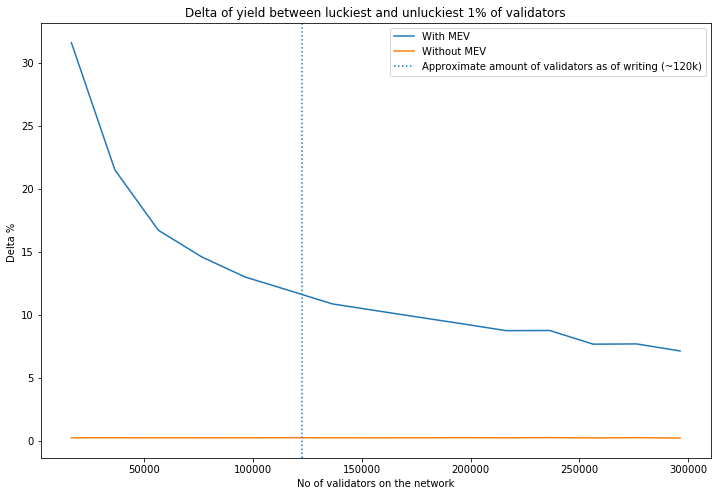

In [5]:
#  delta comp for luckiest/unluckiest 1%, in the context of inequality

n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,20000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
staked = [32 * n for n in n_validators] # ETH actively staked in the network
u_bpo = [int(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators] # blocks produced by luckiest 1%
mean_bpo = [int(binom.ppf(0.5,31556952/12, 1/n)) for n in n_validators]
l_bpo = [int(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators] # blocks produced by unluckiest 1%

full_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
attestation_reward = [0.75 * f for f in full_reward]
inclusion_reward = [0.25 * f for f in full_reward]

ideal_reward_with_mev_luckiest = []
ideal_reward_with_mev_unluckiest = []

for i in range(len(n_validators)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    ideal_reward_with_mev_luckiest.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))
    ideal_reward_with_mev_luckiest[i] = ideal_reward_with_mev_luckiest[i] + (u_bpo[i] * avg_mev_reward_per_block)
    ideal_reward_with_mev_unluckiest.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    ideal_reward_with_mev_unluckiest[i] = ideal_reward_with_mev_unluckiest[i] + (l_bpo[i] * avg_mev_reward_per_block)

ideal_reward_without_mev_luckiest = []
ideal_reward_without_mev_unluckiest = []

for i in range(len(n_validators)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    ideal_reward_without_mev_luckiest.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))
    ideal_reward_without_mev_unluckiest.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))

annual_yield_without_mev_luckiest = [100 * r / 32 for r in ideal_reward_without_mev_luckiest]
annual_yield_without_mev_unluckiest = [100 * r / 32 for r in ideal_reward_without_mev_unluckiest]
annual_yield_with_mev_luckiest = [100 * r / 32 for r in ideal_reward_with_mev_luckiest]
annual_yield_with_mev_unluckiest = [100 * r / 32 for r in ideal_reward_with_mev_unluckiest]

delta_with_mev = []
delta_without_mev = []
for i in range(len(n_validators)):
    delta_with_mev.append(annual_yield_with_mev_luckiest[i] - annual_yield_with_mev_unluckiest[i])
    delta_without_mev.append(annual_yield_without_mev_luckiest[i] - annual_yield_without_mev_unluckiest[i])


fig, ax = plt.subplots(figsize=(12, 8))
ax.plot([n for n in n_validators], [d for d in delta_with_mev], label='With MEV')
ax.plot([n for n in n_validators], [d for d in delta_without_mev], label='Without MEV')

plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~120k)")
ax.set_xlabel('No of validators on the network')
ax.set_ylabel('Delta % ')
ax.set_title('Delta of yield between luckiest and unluckiest 1% of validators')
#ax.set_yscale("log")
leg = ax.legend()

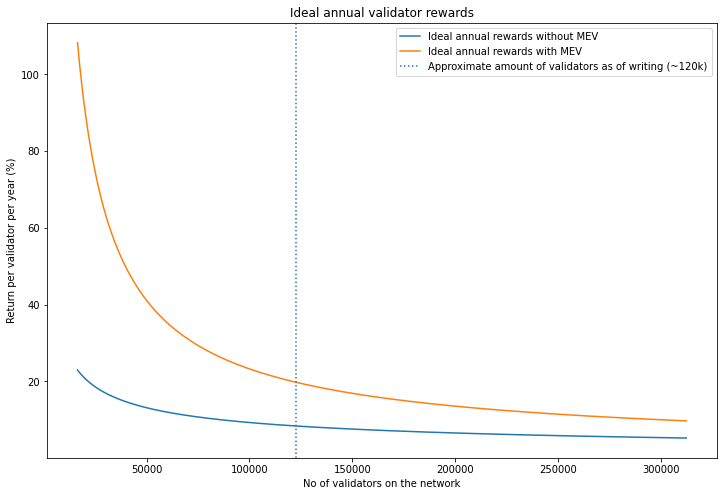

In [7]:
# Ideal, with and without MEV

n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
ideal_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
ideal_reward_with_mev = [(4 * annualised_base_reward(n) +  avg_mev_reward_per_block * average_blocks_proposed_per_year(n)) for n in n_validators]

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([n for n in n_validators], [100 * r / 32 for r in ideal_reward], label='Ideal annual rewards without MEV')
ax.plot([n for n in n_validators], [100 * r / 32 for r in ideal_reward_with_mev], label='Ideal annual rewards with MEV')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~120k)")
ax.set_xlabel('No of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
ax.set_title('Ideal annual validator rewards')
leg = ax.legend()

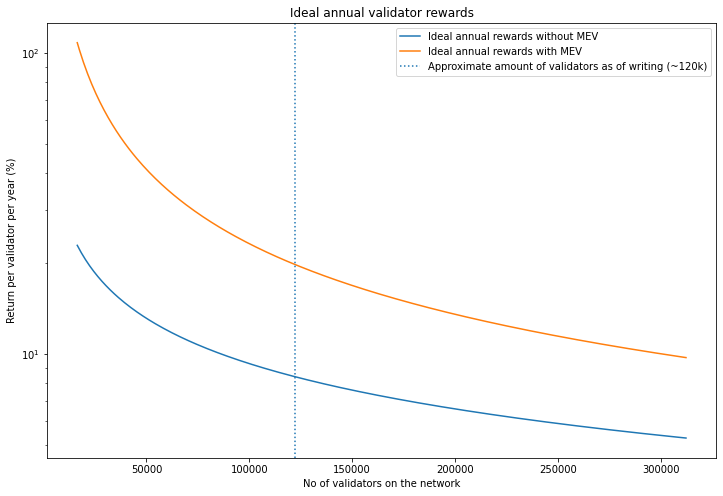

In [8]:
# Ideal, with and without MEV

n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
ideal_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
ideal_reward_with_mev = [(4 * annualised_base_reward(n) +  avg_mev_reward_per_block * average_blocks_proposed_per_year(n)) for n in n_validators]

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([n for n in n_validators], [100 * r / 32 for r in ideal_reward], label='Ideal annual rewards without MEV')
ax.plot([n for n in n_validators], [100 * r / 32 for r in ideal_reward_with_mev], label='Ideal annual rewards with MEV')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~120k)")
ax.set_xlabel('No of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
ax.set_title('Ideal annual validator rewards')
ax.set_yscale("log")
leg = ax.legend()

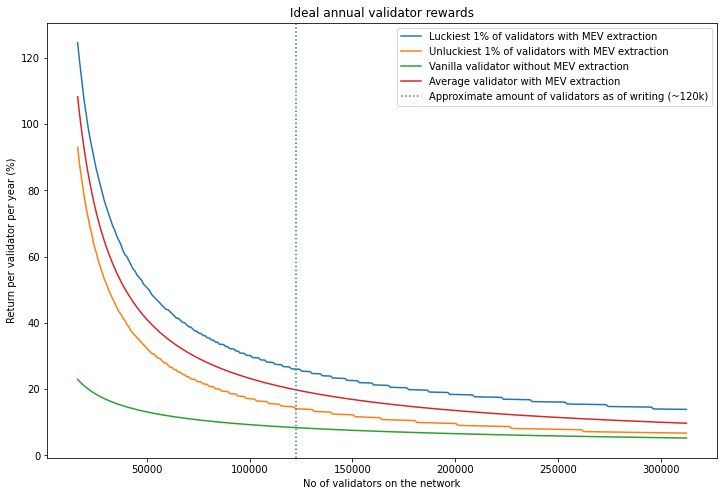

In [9]:
# plot ideal ETH staking return with interpercentile range

n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
full_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
attestation_reward = [0.75 * f for f in full_reward]
inclusion_reward = [0.25 * f for f in full_reward]
p = [1/n for n in n_validators]

# calculate lower and upper quartiles for block proposal opportunities
l_bpo = [int(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators]
mean_bpo = [float(binom.mean(31556952/12, 1/n)) for n in n_validators]
u_bpo = [int(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]


full_reward_with_mev = [(4 * annualised_base_reward(n)+ (avg_mev_reward_per_block * average_blocks_proposed_per_year(n))) for n in n_validators] 

# calculate lower and upper quartiles for ideal reward, based on block proposal opportunties
l_reward, u_reward = [], []
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    l_reward[i] = l_reward[i] + (l_bpo[i] * avg_mev_reward_per_block)
    u_reward.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))
    u_reward[i] = u_reward[i] + (u_bpo[i] * avg_mev_reward_per_block)


fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward] , label='Luckiest 1% of validators with MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward], label='Unluckiest 1% of validators with MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward], label='Vanilla validator without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward_with_mev], label='Average validator with MEV extraction')
ax.set_xlabel('No of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~120k)")
ax.set_title('Ideal annual validator rewards')
leg = ax.legend()

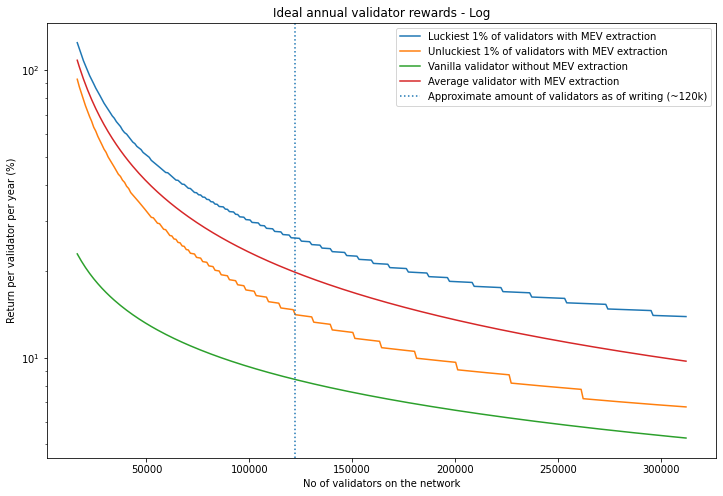

In [10]:
# plot ideal ETH staking return with interpercentile range - Log

n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
full_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
attestation_reward = [0.75 * f for f in full_reward]
inclusion_reward = [0.25 * f for f in full_reward]
p = [1/n for n in n_validators]

# calculate lower and upper quartiles for block proposal opportunities
l_bpo = [int(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators]
mean_bpo = [float(binom.mean(31556952/12, 1/n)) for n in n_validators]
u_bpo = [int(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]


full_reward_with_mev = [(4 * annualised_base_reward(n)+ (avg_mev_reward_per_block * average_blocks_proposed_per_year(n))) for n in n_validators] 

# calculate lower and upper quartiles for ideal reward, based on block proposal opportunties
l_reward, u_reward = [], []
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    l_reward[i] = l_reward[i] + (l_bpo[i] * avg_mev_reward_per_block)
    u_reward.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))
    u_reward[i] = u_reward[i] + (u_bpo[i] * avg_mev_reward_per_block)


fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward] , label='Luckiest 1% of validators with MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward], label='Unluckiest 1% of validators with MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward], label='Vanilla validator without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward_with_mev], label='Average validator with MEV extraction')
ax.set_xlabel('No of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~120k)")
ax.set_title('Ideal annual validator rewards - Log')
ax.set_yscale("log")
leg = ax.legend()

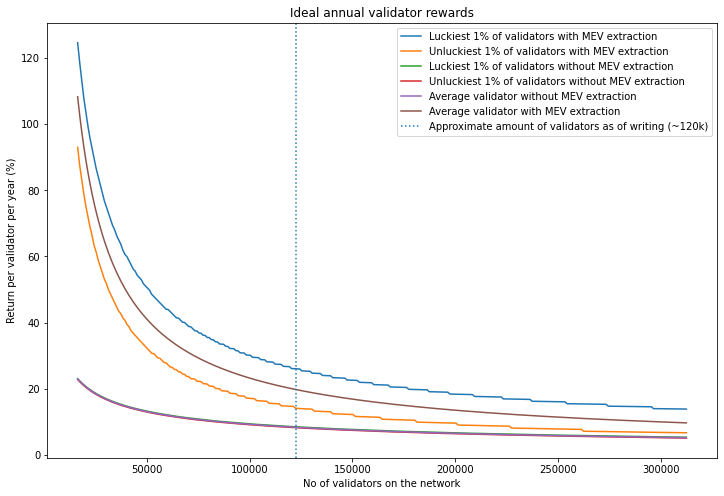

In [11]:
# plot ideal ETH staking return with interpercentile range
# TODO: decide if we want to make it log or not (to show distinction on non-MEV returns)
n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
full_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
attestation_reward = [0.75 * f for f in full_reward]
inclusion_reward = [0.25 * f for f in full_reward]
p = [1/n for n in n_validators]

# calculate lower and upper quartiles for block proposal opportunities
l_bpo = [int(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators]
mean_bpo = [float(binom.mean(31556952/12, 1/n)) for n in n_validators]
u_bpo = [int(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]


full_reward_with_mev = [(4 * annualised_base_reward(n)+ (avg_mev_reward_per_block * average_blocks_proposed_per_year(n))) for n in n_validators] 

# calculate lower and upper quartiles for ideal reward, based on block proposal opportunties
l_reward, u_reward = [], [] # With MEV
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    l_reward[i] = l_reward[i] + (l_bpo[i] * avg_mev_reward_per_block)
    u_reward.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))
    u_reward[i] = u_reward[i] + (u_bpo[i] * avg_mev_reward_per_block)

l_reward_without_mev, u_reward_without_mev = [], []
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    u_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))


fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward] , label='Luckiest 1% of validators with MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward], label='Unluckiest 1% of validators with MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward_without_mev] , label='Luckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward_without_mev], label='Unluckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward], label='Average validator without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward_with_mev], label='Average validator with MEV extraction')
ax.set_xlabel('No of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~120k)")
ax.set_title('Ideal annual validator rewards')
#ax.set_yscale("log")
leg = ax.legend();

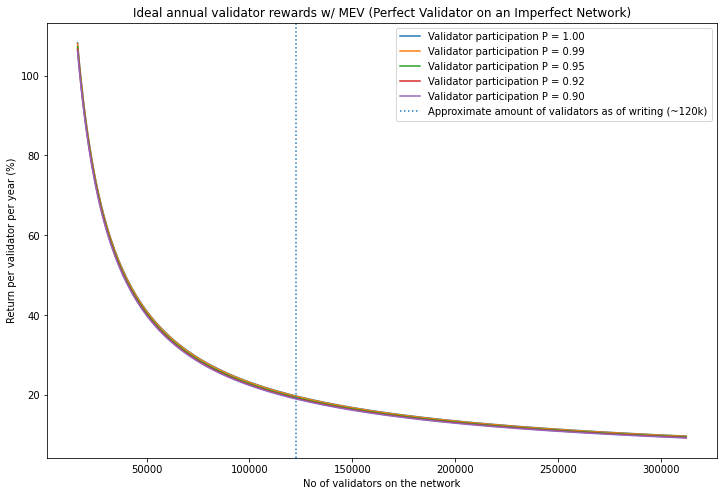

In [12]:
# Perfect validator on an Imperfect Network

# plot reward for perfect validator in several participation level contexts
participation_rate = [1,0.99,0.95,0.92,0.90]

n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)]
base_reward = [annualised_base_reward(n) for n in n_validators]

fig, ax = plt.subplots(figsize=(12, 8))

r_100000 = []
for P in participation_rate:
    accuracy_rewards = [P * 3 * r for r in base_reward]
    if P < 1:
        inclusion_reward = [(7/8) * r * P * math.log(P) / (P-1) for r in base_reward]
    else:
        inclusion_reward = [(7/8) * r for r in base_reward]
        
    block_reward = [(1/8) * r * P for r in base_reward]
    total_reward = [accuracy_rewards[i] + inclusion_reward[i] + block_reward[i]
                    for i in range(len(block_reward))]
    total_reward = [total_reward[i] + (avg_mev_reward_per_block * average_blocks_proposed_per_year(n)) for i, n in enumerate(n_validators)]
    ax.plot([n for n in n_validators], [100 * r / 32 for r in total_reward], label=f'Validator participation P = {P:.2f}')
    r_100000.append(total_reward[50])
    
ax.set_xlabel('No of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~120k)")
ax.set_title('Ideal annual validator rewards w/ MEV (Perfect Validator on an Imperfect Network)')
#ax.set_yscale("log")
leg = ax.legend()

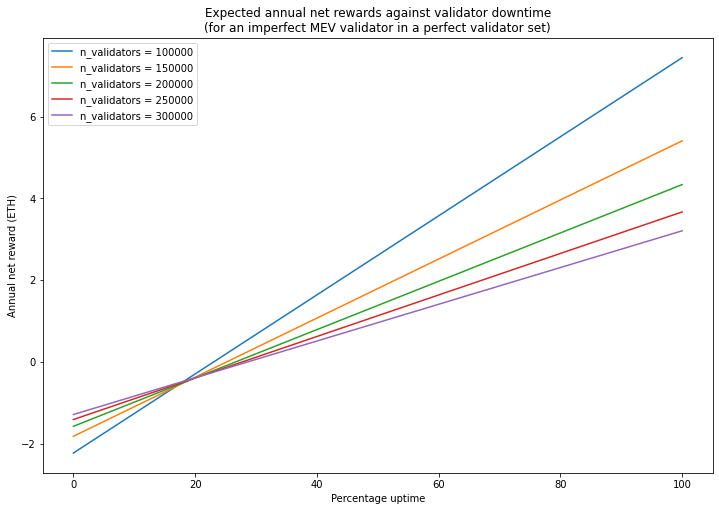

In [13]:
# Imperfect Validator on a Perfect Network

n_validators = [100000, 150000, 200000, 250000, 300000]
uptime = [i / 100 for i in range(101)]

fig, ax = plt.subplots(figsize=(12, 8))
for n in n_validators:
    base_reward = annualised_base_reward(n)
    mev_reward = average_blocks_proposed_per_year(n) * avg_mev_reward_per_block
    net_reward = []
    for u in uptime:
        rewards = 4 * u * base_reward
        penalties = 3 * (1 - u) * base_reward
        mev_reward_adjusted_for_uptime = u * mev_reward
        net_reward.append(rewards - penalties + mev_reward_adjusted_for_uptime)

    ax.plot(range(101), net_reward, label=f'n_validators = {n}')

ax.set_xlabel('Percentage uptime')
ax.set_ylabel('Annual net reward (ETH)')
ax.set_title('Expected annual net rewards against validator downtime\n'
             '(for an imperfect MEV validator in a perfect validator set)')
leg = ax.legend()
#Skewed under 0 because we take average # of blocks proposed, need to repeat for luckiest/unluckiest 1%

In [14]:
## TODO: Confirm if this is right
## Full model - imperfect validator operating in an imperfect validator
base_reward = annualised_base_reward(100000)
participation = 0.99
uptime = 0.99
net_reward = 3 * base_reward * participation * uptime \
             - 3 * base_reward * (1 - participation)  \
             + (7/8) * base_reward * participation * uptime * math.log(participation) / (participation - 1) \
             + (1/8) * base_reward * participation * uptime + (avg_mev_reward_per_block * average_blocks_proposed_per_year(100000) * uptime * participation)

print("Assuming 100000 validators on the network with ", participation*100, "% participaton and", uptime*100, "% network uptimeand" )
print(f'Net annual reward estimate with MEV= {net_reward:.2f} ETH ({100 * net_reward / 32:.2f}% return on 32 ETH stake)')

Assuming 100000 validators on the network with  99.0 % participaton and 99.0 % network uptimeand
Net annual reward estimate with MEV= 7.28 ETH (22.75% return on 32 ETH stake)


In [12]:
# plot reward for perfect validator in several participation level contexts

participation_rate = [1,0.99,0.98,0.97,0.96, 0.95]

n_validators = [n for n in range(50000,int(10e6)//32,1000)]
base_reward = [annualised_base_reward(n) for n in n_validators]


r_100000 = []
for P in participation_rate:
    accuracy_rewards = [P * 3 * r for r in base_reward]
    if P < 1:
        inclusion_reward = [(7/8) * r * P * math.log(P) / (P-1) for r in base_reward]
    else:
        inclusion_reward = [(7/8) * r for r in base_reward]
        
    block_reward = [(1/8) * r * P for r in base_reward]
    mev_reward = [avg_mev_reward_per_block * average_blocks_proposed_per_year(n) for n in n_validators]
    total_reward = [accuracy_rewards[i] + inclusion_reward[i] + block_reward[i] + mev_reward[i]
                    for i in range(len(block_reward))]
    r_100000.append(total_reward[50])
    

print(f'at P = {participation_rate[1]:.2f}, rewards fall by {100 * (1 - r_100000[1] / r_100000[0]):.2f}%')
print(f'at P = {participation_rate[2]:.2f}, rewards fall by {100 * (1 - r_100000[2] / r_100000[0]):.2f}%')
print(f'at P = {participation_rate[3]:.2f}, rewards fall by {100 * (1 - r_100000[3] / r_100000[0]):.2f}%')
print(f'at P = {participation_rate[4]:.2f}, rewards fall by {100 * (1 - r_100000[4] / r_100000[0]):.2f}%')
print(f'at P = {participation_rate[5]:.2f}, rewards fall by {100 * (1 - r_100000[5] / r_100000[0]):.2f}%')

at P = 0.99, rewards fall by 0.36%
at P = 0.98, rewards fall by 0.71%
at P = 0.97, rewards fall by 1.07%
at P = 0.96, rewards fall by 1.43%
at P = 0.95, rewards fall by 1.78%
